# Data cleaning and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [2]:
# Data loading
BookData = pd.read_csv("ForecastDataBookings.csv")

In [3]:
# Split dataset

# Splitting training+Validationset and testset (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(BookData.drop(columns=['Status']),  BookData['Status'],  test_size=0.3,  random_state=42)

# Splitting trainingset and validationset (70: 80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,  y_train_val,  test_size=0.2,  random_state=42)

In [4]:
# Missing values

# Impute missing values with mode for the features Children and Country
# Mode of the trainset
ModeChildren = X_train['Children'].mode()[0]
ModeCountry = X_train['Country'].mode()[0]

# Feature: Children
X_train['Children'] = X_train['Children'].fillna(X_train['Children'].mode()[0])
X_val['Children'] = X_val['Children'].fillna(X_train['Children'].mode()[0])
X_test['Children'] = X_test['Children'].fillna(X_train['Children'].mode()[0])

# Feature: Country
X_train['Country'] = X_train['Country'].fillna(X_train['Country'].mode()[0])
X_val['Country'] = X_val['Country'].fillna(X_train['Country'].mode()[0])
X_test['Country'] = X_test['Country'].fillna(X_train['Country'].mode()[0])


# Drop features because many NULL values, and both have over 300 classes. Computational expensive
#Feature: Agent and Company
X_train = X_train.drop(['Agent', 'Company'], axis=1)
X_val = X_val.drop(['Agent', 'Company'], axis=1)
X_test = X_test.drop(['Agent', 'Company'], axis=1)


In [5]:
# One-hot-encoding for categorical features

# Transform feature IsRepeatedGuest to a category
X_train['IsRepeatedGuest'] = X_train['IsRepeatedGuest'].astype('category')
X_val['IsRepeatedGuest'] = X_val['IsRepeatedGuest'].astype('category')
X_test['IsRepeatedGuest'] = X_test['IsRepeatedGuest'].astype('category')

# Top 25 + Other for feature Country (Top 25 from trainset)
TopN = 25
TopCountries = X_train['Country'].value_counts().nlargest(TopN).index
X_train['Country'] = X_train['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_val['Country'] = X_val['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_test['Country'] = X_test['Country'].apply(lambda x: x if x in TopCountries else 'Other')

# All categorical features
CategoricalFeatures = ['Country',
                       'Hotel',
                       'Meal',
                       'MarketSegment',
                       'DistributionChannel',
                       'ReservedRoomType',
                       'AssignedRoomType',
                       'DepositType',
                       'CustomerType',
                       'IsRepeatedGuest']

# One-hot-encoding CategoricalFeatures
X_train = pd.get_dummies(X_train, columns=CategoricalFeatures, drop_first=False)
X_val = pd.get_dummies(X_val, columns=CategoricalFeatures, drop_first=False)
X_test = pd.get_dummies(X_test, columns=CategoricalFeatures, drop_first=False)

# Consistency between train, validation and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)



In [6]:
# Processing date features

# ArrivalDateMonth from Object to Integer
MonthChange = {
                'January': 1,
                'February': 2,
                'March': 3,
                'April': 4,
                'May': 5,
                'June': 6,
                'July': 7,
                'August': 8,
                'September': 9,
                'October': 10,
                'November': 11,
                'December': 12
            }

X_train['ArrivalDateMonth'] = X_train['ArrivalDateMonth'].map(MonthChange)
X_val['ArrivalDateMonth'] = X_val['ArrivalDateMonth'].map(MonthChange)
X_test['ArrivalDateMonth'] = X_test['ArrivalDateMonth'].map(MonthChange)

# Sinus- and cosinustransformation (Arrival month)
X_train['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateMonth'] / 12)
X_train['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateMonth'] / 12)

X_val['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateMonth'] / 12)
X_val['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateMonth'] / 12)

X_test['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateMonth'] / 12)
X_test['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateMonth'] / 12)

# Sinus- and cosinustransformation (Arrival week). Dataset has 53 weeks in a year.
X_train['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)
X_train['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)

X_val['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)
X_val['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)

X_test['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)
X_test['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)

# Sinus- and cosinustransformation (Arrival day of month)

# Function: Check if the year is a leap year
def IsLeapYear(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# Function: Assign number of days to the months, including the leap year difference for February
def NumberOfDaysInMonth(month, year):
    if month == 2:
        return 29 if IsLeapYear(year) else 28
    return 31 if month in [1, 3, 5, 7, 8, 10, 12] else 30

X_train['ArrivalDateDay_Sin'] = X_train.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_train['ArrivalDateDay_Cos'] = X_train.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_val['ArrivalDateDay_Sin'] = X_val.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_val['ArrivalDateDay_Cos'] = X_val.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_test['ArrivalDateDay_Sin'] = X_test.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_test['ArrivalDateDay_Cos'] = X_test.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

In [7]:
# Drop features that are correlated to other features in the dataset

features_to_drop = ['ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInNights', 'ArrivalDate', 'CheckoutDate', 'ReservationStatusDate']

X_train = X_train.drop(features_to_drop, axis=1)
X_val = X_val.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

# ANN

In [8]:
# Import libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch


# Without SMOTE



In [9]:
#Label encoding for target value

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


# One-hot encoding for activation function softmax

y_train_encoded = to_categorical(y_train_encoded, num_classes=4)
y_val_encoded = to_categorical(y_val_encoded, num_classes=4)
y_test_encoded = to_categorical(y_test_encoded, num_classes=4)




In [10]:
# Feature standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# F1-macro
def f1_macro(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    tp = tf.reduce_sum(tf.cast(y_pred * y_true, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast(y_pred * (1 - y_true), 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast((1 - y_pred) * y_true, 'float'), axis=0)

    f1 = 2 * tp / (2 * tp + fp + fn + K.epsilon())
    return tf.reduce_mean(f1)

# Model creation
def create_model(n_hidden=2, n_neurons=64, activation='relu', dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=X_train_scaled.shape[1], activation=activation,
                    kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=[f1_macro])
    return model

In [14]:
# Hyperparameter tuning


def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6, step=1)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.0001])
    return create_model(n_hidden, n_neurons, activation, dropout_rate, learning_rate)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_tuning',
    project_name='hotel_booking_cancellation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_scaled, y_train_encoded, epochs=20, validation_data=(X_val_scaled, y_val_encoded), verbose=2)


Trial 10 Complete [00h 03m 11s]
val_loss: 0.06970156729221344

Best val_loss So Far: 0.058681245893239975
Total elapsed time: 00h 28m 34s


In [15]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Hidden Layers: {best_hps.get('n_hidden')}
- Neurons per Layer: {best_hps.get('n_neurons')}
- Activation: {best_hps.get('activation')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Best hyperparameters:
- Hidden Layers: 2
- Neurons per Layer: 160
- Activation: relu
- Dropout Rate: 0.4
- Learning Rate: 0.0001



In [16]:
# Final model training
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Predicting train, validation and testset
y_train_pred = final_model.predict(X_train_scaled)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)  # Zorg dat X_test_scaled is voorbereid

# Predictions to class labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# True labels to class labels
y_train_true_classes = np.argmax(y_train_encoded, axis=1)
y_val_true_classes = np.argmax(y_val_encoded, axis=1)
y_test_true_classes = np.argmax(y_test_encoded, axis=1)




Epoch 1/25
2090/2090 - 13s - 6ms/step - f1_macro: 0.6773 - loss: 2.9239 - val_f1_macro: 0.5627 - val_loss: 1.5872
Epoch 2/25
2090/2090 - 5s - 2ms/step - f1_macro: 0.6414 - loss: 1.0105 - val_f1_macro: 0.5577 - val_loss: 0.5468
Epoch 3/25
2090/2090 - 5s - 2ms/step - f1_macro: 0.6552 - loss: 0.3559 - val_f1_macro: 0.5916 - val_loss: 0.2014
Epoch 4/25
2090/2090 - 4s - 2ms/step - f1_macro: 0.6799 - loss: 0.1492 - val_f1_macro: 0.7177 - val_loss: 0.1007
Epoch 5/25
2090/2090 - 4s - 2ms/step - f1_macro: 0.7097 - loss: 0.0918 - val_f1_macro: 0.7169 - val_loss: 0.0744
Epoch 6/25
2090/2090 - 7s - 3ms/step - f1_macro: 0.7155 - loss: 0.0768 - val_f1_macro: 0.6893 - val_loss: 0.0676
Epoch 7/25
2090/2090 - 4s - 2ms/step - f1_macro: 0.7272 - loss: 0.0711 - val_f1_macro: 0.7302 - val_loss: 0.0644
Epoch 8/25
2090/2090 - 5s - 3ms/step - f1_macro: 0.7339 - loss: 0.0695 - val_f1_macro: 0.7121 - val_loss: 0.0632
Epoch 9/25
2090/2090 - 9s - 4ms/step - f1_macro: 0.7323 - loss: 0.0682 - val_f1_macro: 0.7021 -

Train Set Results
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     42189
           1       0.79      0.80      0.80     19191
           2       0.86      0.06      0.11      4786
           3       0.41      0.03      0.06       692

    accuracy                           0.82     66858
   macro avg       0.72      0.46      0.46     66858
weighted avg       0.82      0.82      0.80     66858



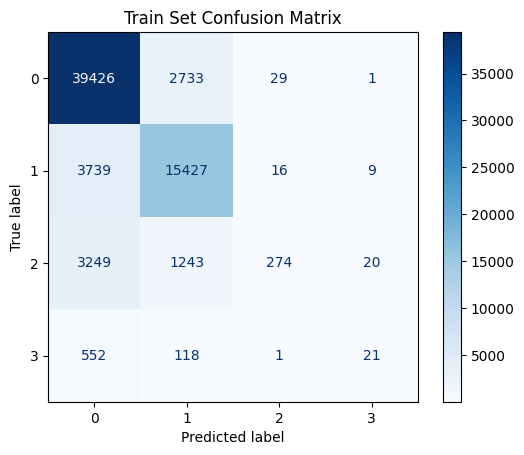

Validation Set Results
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     10499
           1       0.79      0.81      0.80      4817
           2       0.87      0.05      0.09      1233
           3       0.38      0.03      0.06       166

    accuracy                           0.82     16715
   macro avg       0.72      0.46      0.46     16715
weighted avg       0.82      0.82      0.79     16715



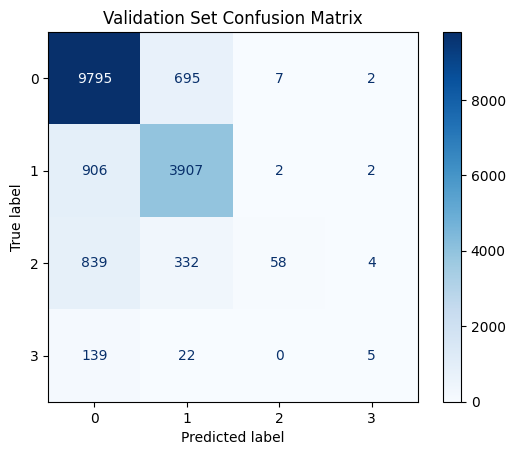

Test Set Results
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     22478
           1       0.00      0.00      0.00     10433
           2       0.00      0.00      0.00      2557
           3       0.00      0.00      0.00       349

    accuracy                           0.63     35817
   macro avg       0.16      0.25      0.19     35817
weighted avg       0.39      0.63      0.48     35817



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


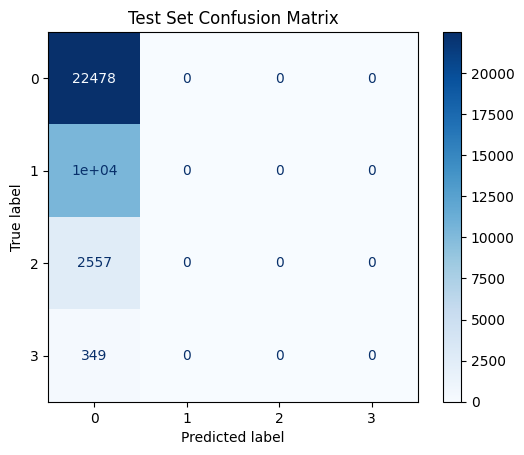

In [17]:
# Evaluation with classification report and confusion matrix

# Train Set Results
print("Train Set Results")
print(classification_report(y_train_true_classes, y_train_pred_classes))
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation Set Results
print("Validation Set Results")
print(classification_report(y_val_true_classes, y_val_pred_classes))
val_cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test Set Results
print("Test Set Results")
print(classification_report(y_test_true_classes, y_test_pred_classes))
test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()

## With SMOTE

In [9]:
#Label encoding for target value

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


# One-hot encoding for activation function softmax

y_train_encoded = to_categorical(y_train_encoded, num_classes=4)
y_val_encoded = to_categorical(y_val_encoded, num_classes=4)
y_test_encoded = to_categorical(y_test_encoded, num_classes=4)




In [10]:
# Smote for class imbalances

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

print("Class distribution before SMOTE:", Counter(y_train_encoded.argmax(axis=1)))
print("Class distribution after SMOTE:", Counter(y_train_smote.argmax(axis=1)))

Class distribution before SMOTE: Counter({0: 42189, 1: 19191, 2: 4786, 3: 692})
Class distribution after SMOTE: Counter({0: 42189, 2: 42189, 1: 42189, 3: 42189})


In [11]:
# Feature standardisation
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# F1-macro
def f1_macro(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    tp = tf.reduce_sum(tf.cast(y_pred * y_true, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast(y_pred * (1 - y_true), 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast((1 - y_pred) * y_true, 'float'), axis=0)

    f1 = 2 * tp / (2 * tp + fp + fn + K.epsilon())
    return tf.reduce_mean(f1)

# Model creation
def create_model(n_hidden=2, n_neurons=64, activation='relu', dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=X_train_smote.shape[1], activation=activation,
                    kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=[f1_macro])
    return model

In [13]:
# Hyperparameter tuning


def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6, step=1)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.0001])
    return create_model(n_hidden, n_neurons, activation, dropout_rate, learning_rate)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_tuning',
    project_name='hotel_booking_cancellation'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train_smote, y_train_smote, epochs=20, validation_data=(X_val_scaled, y_val_encoded), verbose=2)


Trial 10 Complete [00h 05m 01s]
val_loss: 0.06227662041783333

Best val_loss So Far: 0.06227662041783333
Total elapsed time: 00h 55m 33s


In [14]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Hidden Layers: {best_hps.get('n_hidden')}
- Neurons per Layer: {best_hps.get('n_neurons')}
- Activation: {best_hps.get('activation')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Learning Rate: {best_hps.get('learning_rate')}
""")



Best hyperparameters:
- Hidden Layers: 3
- Neurons per Layer: 64
- Activation: relu
- Dropout Rate: 0.2
- Learning Rate: 0.0001



In [15]:
# Final model training
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val_scaled, y_val_encoded),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Predicting train, validation and testset
y_train_pred = final_model.predict(X_train_smote)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)  # Zorg dat X_test_scaled is voorbereid

# Predictions to class labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# True labels to class labels
y_train_true_classes = np.argmax(y_train_smote, axis=1)
y_val_true_classes = np.argmax(y_val_encoded, axis=1)
y_test_true_classes = np.argmax(y_test_encoded, axis=1)




Epoch 1/25
5274/5274 - 22s - 4ms/step - f1_macro: 1.8107 - loss: 1.4814 - val_f1_macro: 0.8253 - val_loss: 0.5132
Epoch 2/25
5274/5274 - 12s - 2ms/step - f1_macro: 2.0866 - loss: 0.2711 - val_f1_macro: 0.8381 - val_loss: 0.1190
Epoch 3/25
5274/5274 - 22s - 4ms/step - f1_macro: 2.1487 - loss: 0.1047 - val_f1_macro: 0.8311 - val_loss: 0.0762
Epoch 4/25
5274/5274 - 19s - 4ms/step - f1_macro: 2.1706 - loss: 0.0801 - val_f1_macro: 0.8480 - val_loss: 0.0713
Epoch 5/25
5274/5274 - 21s - 4ms/step - f1_macro: 2.1765 - loss: 0.0720 - val_f1_macro: 0.8542 - val_loss: 0.0651
Epoch 6/25
5274/5274 - 19s - 4ms/step - f1_macro: 2.1812 - loss: 0.0685 - val_f1_macro: 0.8942 - val_loss: 0.0651
Epoch 7/25
5274/5274 - 12s - 2ms/step - f1_macro: 2.1844 - loss: 0.0668 - val_f1_macro: 0.8718 - val_loss: 0.0640
Epoch 8/25
5274/5274 - 12s - 2ms/step - f1_macro: 2.1882 - loss: 0.0657 - val_f1_macro: 0.8540 - val_loss: 0.0625
Epoch 9/25
5274/5274 - 21s - 4ms/step - f1_macro: 2.1879 - loss: 0.0647 - val_f1_macro: 

Train Set Results
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     42189
           1       0.82      0.76      0.79     42189
           2       0.80      0.73      0.76     42189
           3       0.89      0.94      0.91     42189

    accuracy                           0.83    168756
   macro avg       0.83      0.83      0.83    168756
weighted avg       0.83      0.83      0.83    168756



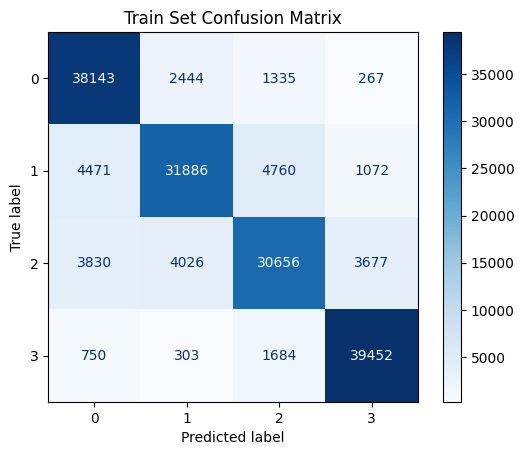

Validation Set Results
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     10499
           1       0.81      0.76      0.79      4817
           2       0.43      0.29      0.34      1233
           3       0.19      0.19      0.19       166

    accuracy                           0.81     16715
   macro avg       0.57      0.54      0.55     16715
weighted avg       0.80      0.81      0.80     16715



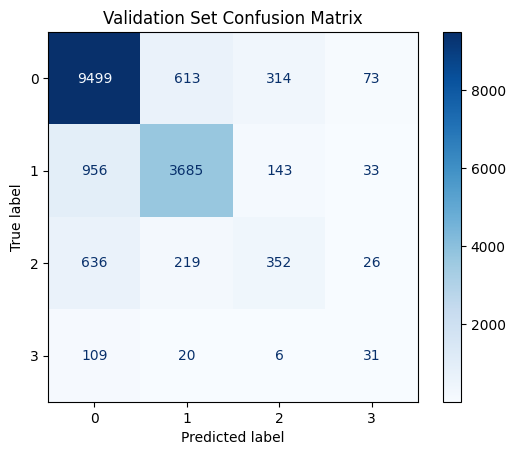

Test Set Results
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     22478
           1       0.00      0.00      0.00     10433
           2       0.00      0.00      0.00      2557
           3       0.00      0.00      0.00       349

    accuracy                           0.63     35817
   macro avg       0.16      0.25      0.19     35817
weighted avg       0.39      0.63      0.48     35817



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


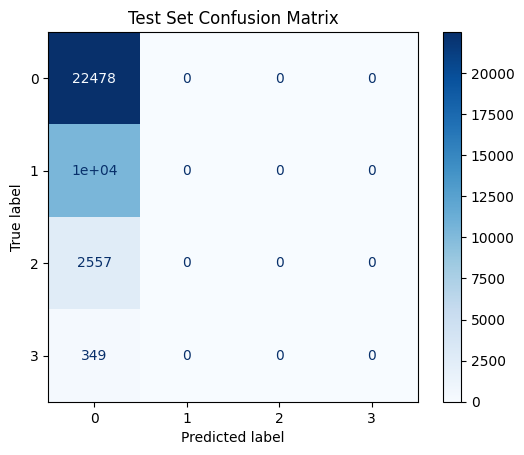

In [16]:
# Evaluation with classification report and confusion matrix

# Train Set Results
print("Train Set Results")
print(classification_report(y_train_true_classes, y_train_pred_classes))
train_cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation Set Results
print("Validation Set Results")
print(classification_report(y_val_true_classes, y_val_pred_classes))
val_cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test Set Results
print("Test Set Results")
print(classification_report(y_test_true_classes, y_test_pred_classes))
test_cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()

## Feature Importance Analysis

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        # Voor multiclass classificatie met 4 klassen
        self.classes_ = np.array([0, 1, 2, 3])  # Vier klassen

    def fit(self, X, y):
        # Train het Keras-model
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        # Voorspel de labels voor de gegeven data
        return np.argmax(self.model.predict(X), axis=1)  # Zet output om naar de klasse

    def predict_proba(self, X):
        # De probabiliteit van de voorspellingen (nodig voor sommige evaluaties)
        return self.model.predict(X)  # Deze geeft de waarschijnlijkheden voor elke klasse


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━

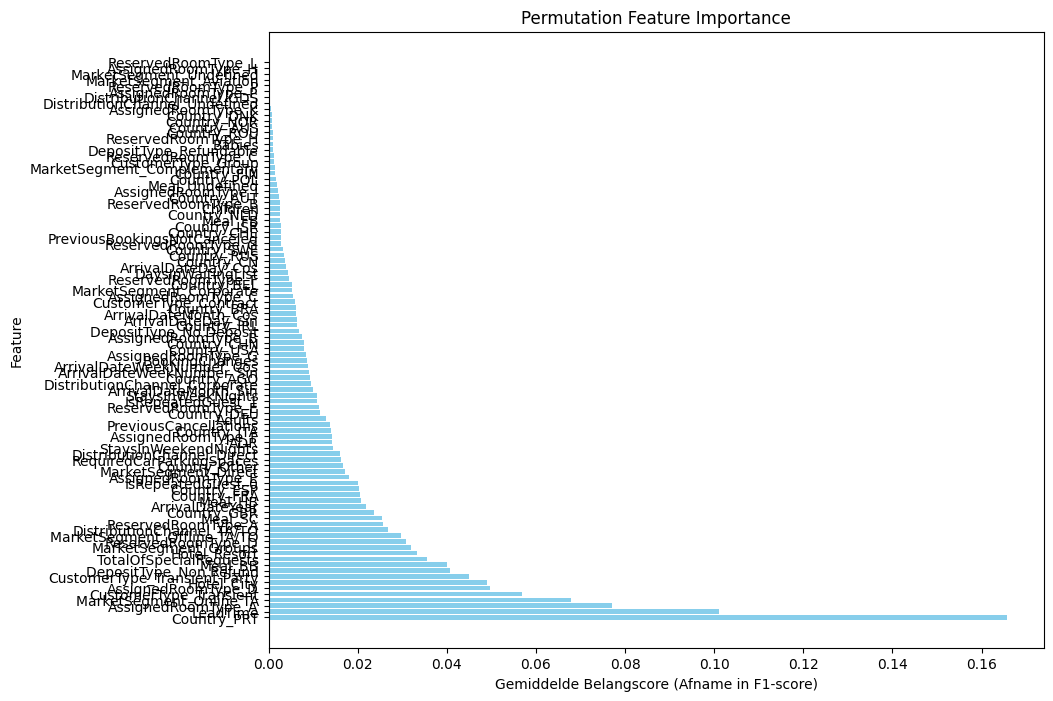

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

feature_names = X_train.columns.tolist()


wrapped_model = KerasModelWrapper(final_model)

# Permutation importance on validation set
perm_importance = permutation_importance(
    wrapped_model,
    X_val_scaled, 
    y_val_true_classes,
    n_repeats=10, 
    random_state=42, 
    scoring='f1_macro'
)

# Sorting
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1] 

# visualisationMaak de grafiek
plt.figure(figsize=(10, 8)) 
plt.barh(
    [feature_names[i] for i in sorted_idx],  
    perm_importance.importances_mean[sorted_idx],
    color='skyblue'
)
plt.xlabel("Gemiddelde Belangscore (Afname in F1-score)") 
plt.ylabel("Feature")  # Label voor de y-as
plt.title("Permutation Feature Importance") 
plt.show()


                    Feature  Mean Importance  Importance StdDev
0               Country_PRT         0.165631           0.003649
1                  LeadTime         0.101023           0.003659
2        AssignedRoomType_A         0.077058           0.003295
3   MarketSegment_Online TA         0.067882           0.002389
4    CustomerType_Transient         0.056901           0.001273
..                      ...              ...                ...
91       ReservedRoomType_P         0.000175           0.000433
92   MarketSegment_Aviation         0.000076           0.000427
93  MarketSegment_Undefined         0.000039           0.000065
94       AssignedRoomType_H         0.000034           0.000781
95       ReservedRoomType_L         0.000008           0.000017

[96 rows x 3 columns]
Top Features:
                         Feature  Mean Importance  Importance StdDev
0                    Country_PRT         0.165631           0.003649
1                       LeadTime         0.101023        

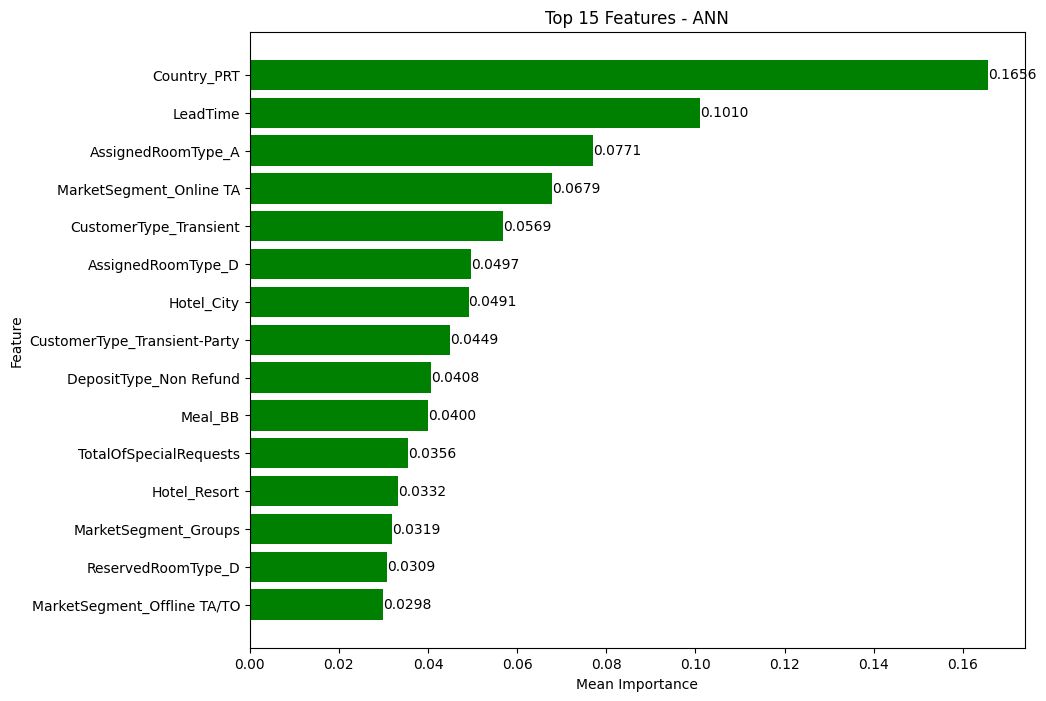

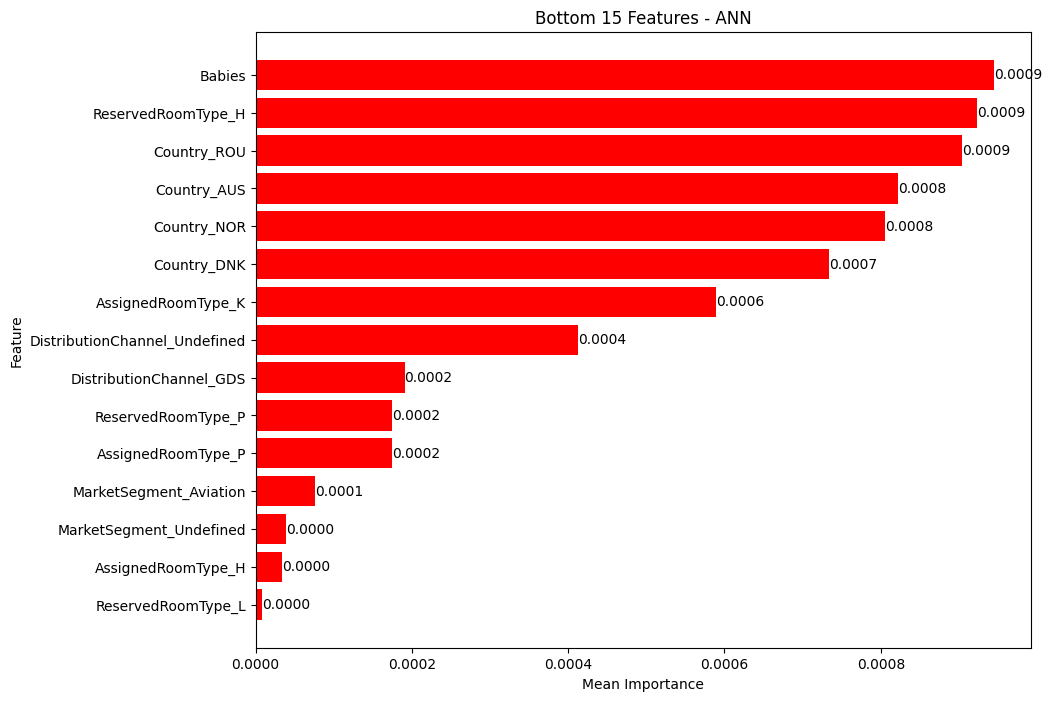

In [23]:
# Important features
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in sorted_idx],
    'Mean Importance': perm_importance.importances_mean[sorted_idx],
    'Importance StdDev': perm_importance.importances_std[sorted_idx]
}).sort_values(by='Mean Importance', ascending=False)

print(importance_df)

# Top and bottom features
top_n = 15
top_features = importance_df.head(top_n)
bottom_features = importance_df.tail(top_n)

top_features.reset_index(drop=True, inplace=True)
bottom_features.reset_index(drop=True, inplace=True)

print("Top Features:")
print(top_features)

print("\nBottom Features:")
print(bottom_features)

# Visualisation top features
top_features_sorted = top_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features_sorted['Feature'], top_features_sorted['Mean Importance'], color='green')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Top 15 Features - ANN")

for bar, value in zip(bars, top_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()

# Visualisation bottom features
bottom_features_sorted = bottom_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(bottom_features_sorted['Feature'], bottom_features_sorted['Mean Importance'], color='red')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Bottom 15 Features - ANN")

for bar, value in zip(bars, bottom_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()


## New model with selected features

In [24]:
# Threshold for important features
importance_threshold = 0.001


important_features_idx = [i for i in sorted_idx if perm_importance.importances_mean[i] > importance_threshold]


selected_feature_names = [feature_names[i] for i in important_features_idx]


print(f"Number of selected features: {len(selected_feature_names)}")



Aantal geselecteerde features: 81


In [25]:
# Filtering train, validation, and test sets
X_train_filtered = X_train_smote[:, important_features_idx]
X_val_filtered = X_val_scaled[:, important_features_idx]
X_test_filtered = X_test_scaled[:, important_features_idx]

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K
from keras.regularizers import l2
import tensorflow as tf

# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

# F1-macro
def f1_macro(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    tp = tf.reduce_sum(tf.cast(y_pred * y_true, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast(y_pred * (1 - y_true), 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast((1 - y_pred) * y_true, 'float'), axis=0)

    f1 = 2 * tp / (2 * tp + fp + fn + K.epsilon())
    return tf.reduce_mean(f1)

# Model creation
def create_model_with_selected_features(n_hidden=2, n_neurons=64, activation='relu', dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.01):
    model = Sequential()


    input_dim = X_train_filtered.shape[1] 
    model.add(Dense(n_neurons, input_dim=input_dim, activation=activation, kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))


    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)


    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=[f1_macro])

    return model


In [27]:
# Hyperparameter tuning
def build_model_with_selected_features(hp):
    n_hidden = hp.Int('n_hidden', min_value=2, max_value=6, step=1)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=256, step=16)
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001])


    input_dim = X_train_filtered.shape[1]
    return create_model_with_selected_features(n_hidden, n_neurons, activation, dropout_rate, learning_rate)

tuner_selected = RandomSearch(
    build_model_with_selected_features,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_tuning',
    project_name='hotel_booking_cancellation_selected_features'
)

tuner_selected.search(
    X_train_filtered, y_train_smote,
    epochs=20,
    validation_data=(X_val_filtered, y_val_encoded),
    verbose=2
)


Trial 10 Complete [00h 06m 35s]
val_loss: 0.08943261206150055

Best val_loss So Far: 0.07927202433347702
Total elapsed time: 00h 57m 40s


In [28]:
# Best hyperparameters with selected features
best_hps_selected = tuner_selected.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters with selected features:
- Hidden Layers: {best_hps_selected.get('n_hidden')}
- Neurons per Layer: {best_hps_selected.get('n_neurons')}
- Activation: {best_hps_selected.get('activation')}
- Dropout Rate: {best_hps_selected.get('dropout_rate')}
- Learning Rate: {best_hps_selected.get('learning_rate')}
""")


Best hyperparameters with selected features:
- Hidden Layers: 2
- Neurons per Layer: 144
- Activation: sigmoid
- Dropout Rate: 0.2
- Learning Rate: 0.0001



In [29]:
# Training the final model
final_model_selected = tuner_selected.hypermodel.build(best_hps_selected)
final_model_selected.fit(
    X_train_filtered, y_train_smote,
    validation_data=(X_val_filtered, y_val_encoded),
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)



Epoch 1/25
5274/5274 - 18s - 3ms/step - f1_macro: 1.9831 - loss: 1.1528 - val_f1_macro: 0.8266 - val_loss: 0.1936
Epoch 2/25
5274/5274 - 11s - 2ms/step - f1_macro: 2.0573 - loss: 0.1387 - val_f1_macro: 0.8369 - val_loss: 0.0959
Epoch 3/25
5274/5274 - 11s - 2ms/step - f1_macro: 2.0695 - loss: 0.1012 - val_f1_macro: 0.8391 - val_loss: 0.0930
Epoch 4/25
5274/5274 - 21s - 4ms/step - f1_macro: 2.0685 - loss: 0.0991 - val_f1_macro: 0.8243 - val_loss: 0.0895
Epoch 5/25
5274/5274 - 20s - 4ms/step - f1_macro: 2.0692 - loss: 0.0992 - val_f1_macro: 0.8052 - val_loss: 0.0838
Epoch 6/25
5274/5274 - 11s - 2ms/step - f1_macro: 2.0690 - loss: 0.0991 - val_f1_macro: 0.8328 - val_loss: 0.0842
Epoch 7/25
5274/5274 - 20s - 4ms/step - f1_macro: 2.0722 - loss: 0.0987 - val_f1_macro: 0.8310 - val_loss: 0.0851
Epoch 8/25
5274/5274 - 20s - 4ms/step - f1_macro: 2.0712 - loss: 0.0986 - val_f1_macro: 0.8264 - val_loss: 0.0848
Epoch 9/25
5274/5274 - 11s - 2ms/step - f1_macro: 2.0701 - loss: 0.0984 - val_f1_macro: 

In [30]:
# Predicting
y_train_pred_selected = final_model_selected.predict(X_train_filtered)
y_val_pred_selected = final_model_selected.predict(X_val_filtered)
y_test_pred_selected = final_model_selected.predict(X_test_filtered)

# Prediction to class labels
y_train_pred_classes_selected = np.argmax(y_train_pred_selected, axis=1)
y_val_pred_classes_selected = np.argmax(y_val_pred_selected, axis=1)
y_test_pred_classes_selected = np.argmax(y_test_pred_selected, axis=1)

5274/5274 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Train Set Results (Selected Features)
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     42189
           1       0.68      0.69      0.69     42189
           2       0.57      0.55      0.56     42189
           3       0.70      0.65      0.67     42189

    accuracy                           0.68    168756
   macro avg       0.68      0.68      0.68    168756
weighted avg       0.68      0.68      0.68    168756



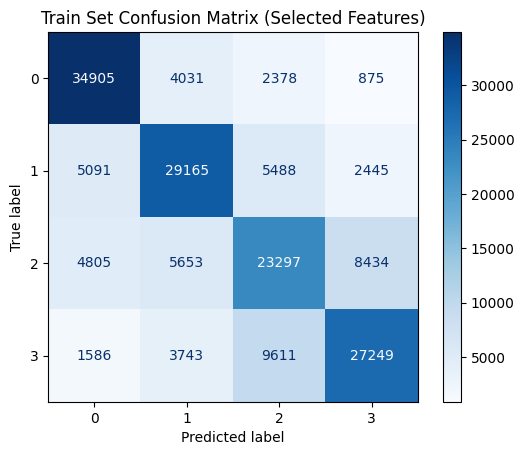

Validation Set Results (Selected Features)
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     10499
           1       0.72      0.73      0.73      4817
           2       0.25      0.22      0.23      1233
           3       0.08      0.18      0.11       166

    accuracy                           0.75     16715
   macro avg       0.47      0.49      0.48     16715
weighted avg       0.75      0.75      0.75     16715



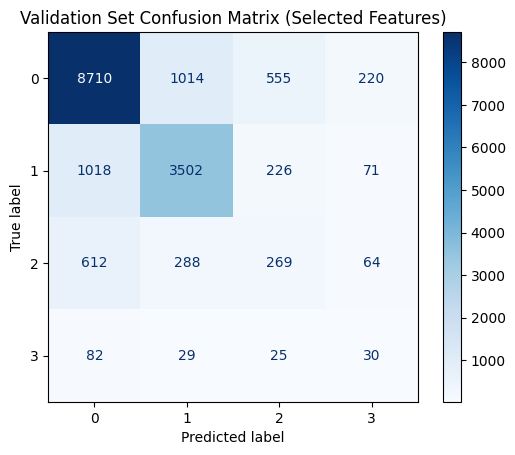

Test Set Results (Selected Features)
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     22478
           1       0.73      0.72      0.72     10433
           2       0.27      0.26      0.26      2557
           3       0.07      0.15      0.10       349

    accuracy                           0.75     35817
   macro avg       0.48      0.49      0.48     35817
weighted avg       0.76      0.75      0.75     35817



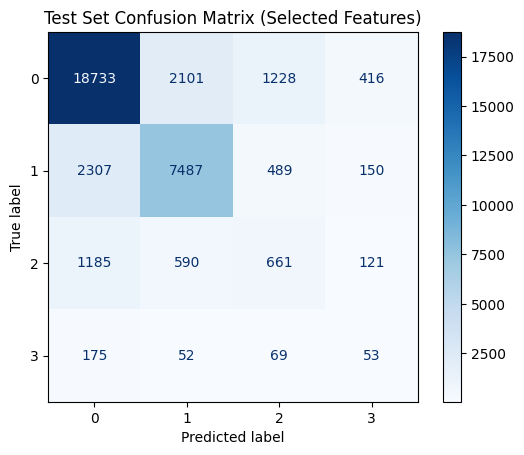

In [31]:
# Train Set Results
print("Train Set Results (Selected Features)")
print(classification_report(y_train_true_classes, y_train_pred_classes_selected))
train_cm_selected = confusion_matrix(y_train_true_classes, y_train_pred_classes_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm_selected)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix (Selected Features)")
plt.show()

# Validation Set Results
print("Validation Set Results (Selected Features)")
print(classification_report(y_val_true_classes, y_val_pred_classes_selected))
val_cm_selected = confusion_matrix(y_val_true_classes, y_val_pred_classes_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm_selected)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix (Selected Features)")
plt.show()

# Test Set Results
print("Test Set Results (Selected Features)")
print(classification_report(y_test_true_classes, y_test_pred_classes_selected))
test_cm_selected = confusion_matrix(y_test_true_classes, y_test_pred_classes_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_selected)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix (Selected Features)")
plt.show()
